**Import Essential Packages**

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


**Training, Testing, Validation sets**

In [ ]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


label_map = {
    "tetragonal": 0,
    "orthorhombic": 1,
    "trigonal": 2,
    "cubic": 3,
    "triclinic": 4,
    "monoclinic": 5,
    "hexagonal": 6
}

# 自定義 Dataset
class XRD_Dataset(Dataset):
    def __init__(self, file_list, data_dir):
        self.file_list = file_list
        self.data_dir = data_dir

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name, label = self.file_list[idx]

        # 將 .cif 檔名更改為 .npz
        file_name = file_name.replace('.cif', '_convolved.npz')

        file_path = os.path.join(self.data_dir, file_name)
        data = np.load(file_path)
        x = data['y_convolved'].astype(np.float32)
        # Map string label to integer index
        label = label_map[label]
        return x, label

# 讀取 csv 文件
csv_path = "/content/drive/MyDrive/xrd_model_training/structure_info.csv"  # 替換為實際 csv 文件路徑
!unzip /content/drive/MyDrive/xrd_model_training/output_data.zip -d /content/drive/MyDrive/xrd_model_training
data_dir = "/content/drive/MyDrive/xrd_model_training/output_data"  # 包含 .npz 文件的目錄
df = pd.read_csv(csv_path)



Archive:  /content/drive/MyDrive/xrd_model_training/output_data.zip
   creating: /content/drive/MyDrive/xrd_model_training/output_data/
  inflating: /content/drive/MyDrive/xrd_model_training/output_data/2102741_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_model_training/output_data/1534635_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_model_training/output_data/1530946_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_model_training/output_data/1536471_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_model_training/output_data/1522037_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_model_training/output_data/7042315_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_model_training/output_data/1530816_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_model_training/output_data/1536521_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_model_training/output_data/2230843_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_model

In [4]:
class XRD_Dataset(Dataset):
    def __init__(self, file_list, data_dir):
        self.file_list = file_list
        self.data_dir = data_dir

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name, label = self.file_list[idx]

        # 將 .cif 檔名更改為 .npz
        file_name = file_name.replace('.cif', '_convolved.npz')

        file_path = os.path.join(self.data_dir, file_name)
        data = np.load(file_path)
        x = data['y_convolved'].astype(np.float32)
        # Map string label to integer index
        label = label_map[label]
        return x, label

In [5]:
# 分割數據集
split_info = {
    "tetragonal": (1000, 1000, 100),
    "orthorhombic": (1000, 1000, 100),
    "trigonal": (1000, 1000, 100),
    "cubic": (1000, 1000, 100),
    "triclinic": (1000, 1000, 100),
    "monoclinic": (1000, 1000, 100),
    "hexagonal": (100, 100, 5)
}

train_list, test_list, val_list = [], [], []

for label, (train_size, test_size, val_size) in split_info.items():
    files = df[df['cell_structure'] == label][['filename', 'cell_structure']].values.tolist()

    # 分割成訓練、測試、驗證集
    train_files, temp_files = train_test_split(files, train_size=train_size, random_state=42)
    test_files, temp_files = train_test_split(temp_files, train_size=test_size, random_state=42)
    val_files, temp_files = train_test_split(temp_files, train_size=val_size, random_state=42)

    train_list.extend(train_files)
    test_list.extend(test_files)
    val_list.extend(val_files)

# 創建 DataLoader
batch_size = 32

train_dataset = XRD_Dataset(train_list, data_dir)
test_dataset = XRD_Dataset(test_list, data_dir)
val_dataset = XRD_Dataset(val_list, data_dir)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("數據加載完成：")
print(f"訓練集樣本數: {len(train_dataset)}")
print(f"測試集樣本數: {len(test_dataset)}")
print(f"驗證集樣本數: {len(val_dataset)}")



數據加載完成：
訓練集樣本數: 6100
測試集樣本數: 6100
驗證集樣本數: 605


In [6]:
print(f"Number of batches in train_loader: {len(test_loader)}")

Number of batches in train_loader: 191


In [7]:
for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    print(f"Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")
    break  # Only for verification

Inputs shape: torch.Size([32, 8500]), Labels shape: torch.Size([32])


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [9]:
def evaluate_model(model, data_loader):
    # Ensure GPU usage if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()  # Set the model to evaluation mode
    model = model.to(device)  # Move model to the GPU or CPU

    correct = 0
    total = 0
    iter = 0
    with torch.no_grad():  # No gradients needed during evaluation
        for inputs, labels in data_loader:

            # Move inputs and labels to the same device as the model
            inputs, labels = inputs.to(device), labels.to(device)

            # Permute inputs if required for the model's expected input shape
            #inputs = inputs.permute(0, 2, 1)  # (batch_size, 8500, 2) -> (batch_size, 2, 8500)

            # Perform a forward pass and compute predictions
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Update total samples and correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate and print accuracy
    accuracy = 100 * correct / total if total > 0 else 0
    print(f"Accuracy: {accuracy:.2f}%")


**Define CNN Model**

In [ ]:
import torch
import torch.nn as nn

class XRD_CNN(nn.Module):
    def __init__(self, num_classes):
        super(XRD_CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        #self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.dropout = nn.Dropout(0.5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 2125, 160)  # 1062 是 8500 經過 3 次 MaxPooling1d(2) 後的大小
        self.fc2 = nn.Linear(160, num_classes)  # `num_classes` 是 cell_structure 的種類數

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        #x = torch.relu(self.conv3(x))
        #x = self.pool(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # 最後一層輸出 logits
        return x


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class XRD_CNN(nn.Module):
    def __init__(self, num_classes):
        super(XRD_CNN, self).__init__()
        # First convolution block
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=80, kernel_size=100, stride=5)
        self.dropout1 = nn.Dropout(0.3)
        self.pool1 = nn.AvgPool1d(kernel_size=3, stride = 2)

        # Second convolution block
        self.conv2 = nn.Conv1d(in_channels=80, out_channels=80, kernel_size=50, stride=5)
        self.dropout2 = nn.Dropout(0.3)
        self.pool2 = nn.AvgPool1d(kernel_size=3)

        # Third convolution block
        self.conv3 = nn.Conv1d(in_channels=80, out_channels=80, kernel_size=25, stride=2)
        self.dropout3 = nn.Dropout(0.3)
        self.pool3 = nn.AvgPool1d(kernel_size=3)

        # Flatten layer
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(1120, 700)  # 10 is calculated after pooling layers for input size 8500
        self.fc2 = nn.Linear(700, 70)
        self.fc3 = nn.Linear(70, num_classes)

        # Dropouts for dense layers
        self.dropout_fc1 = nn.Dropout(0.5)
        self.dropout_fc2 = nn.Dropout(0.5)

    def forward(self, x):
        # First convolution block
        x = F.relu(self.conv1(x))
        # x = self.dropout1(x)
        x = self.pool1(x)

        # Second convolution block
        x = F.relu(self.conv2(x))
        # x = self.dropout2(x)
        x = self.pool2(x)

        # Third convolution block
        x = F.relu(self.conv3(x))
        # x = self.dropout3(x)
        x = self.pool3(x)

        # Flatten the feature maps
        x = self.flatten(x)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout_fc1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout_fc2(x)
        x = self.fc3(x)  # logits output

        return x


In [19]:
import torch
import torch.nn as nn

class XRD_CNN(nn.Module):
    def __init__(self, num_classes):
        super(XRD_CNN, self).__init__()
        self.fc1 = nn.Linear(8500, 4000)  # Input size: 8500, Output size: 4000
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(4000, 2000)  # Input size: 4000, Output size: 3000
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(2000, 700)  # Input size: 3000, Output size: 1000
        self.dropout3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(700, 300)   # Input size: 1000, Output size: 800
        self.dropout4 = nn.Dropout(0.2)
        self.fc5 = nn.Linear(300, num_classes)  # Final layer, Output size: `num_classes`

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        x = torch.relu(self.fc4(x))
        x = self.dropout4(x)
        x = self.fc5(x)
        return x

# Example usage:
# Number of output classes
num_classes = 7




**Training**

In [20]:
# 定義類別數量（如晶系數量）
num_classes = 7

# 初始化模型
model = XRD_CNN(num_classes=num_classes).to(device)
print(model)

# 定義損失函數與優化器
criterion = nn.CrossEntropyLoss()  # 用於分類問題
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-8)

# Function to add Gaussian noise to the loss
#def noisy_loss(loss, std_dev=0.01):
    #noise = torch.randn_like(loss) * std_dev
    #return loss + noise

# 訓練範例
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        iterator = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            #inputs = inputs.permute(0, 2, 1).to(device)   # (batch_size, 8500, 2) -> (batch_size, 2, 8500)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            if iterator%100 == 0:
              print(f"Loss = {loss.item()}")
            iterator = iterator + 1
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        torch.save(model, "/content/drive/MyDrive/xrd_model_training/CNN.pt")
        evaluate_model(model, val_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


XRD_CNN(
  (fc1): Linear(in_features=8500, out_features=4000, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=4000, out_features=2000, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=2000, out_features=700, bias=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=700, out_features=300, bias=True)
  (dropout4): Dropout(p=0.2, inplace=False)
  (fc5): Linear(in_features=300, out_features=7, bias=True)
)


In [ ]:
import torch
import torch.nn as nn

# Function to add Gaussian noise to the loss
def noisy_loss(loss, std_dev=0.01):
    noise = torch.randn_like(loss) * std_dev
    return loss + noise

# Train function with noise added to MSELoss
def train_model(model, train_loader, val_loader, optimizer, num_epochs=10, noise_std=0.01):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        iterator = 0

        criterion = nn.MSELoss()  # Use MSELoss for all epochs

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()  # Reset gradients
            outputs = model(inputs)  # Forward pass

            # Convert labels to one-hot encoded vectors for MSELoss
            target = torch.zeros(labels.size(0), num_classes).to(device)
            for i in range(labels.size(0)):
                target[i, labels[i]] = 1  # One-hot encoding (set the correct class to 1)

            # Calculate MSE loss
            loss = criterion(outputs, target)

            # Add noise to the loss
            loss_with_noise = noisy_loss(loss, std_dev=noise_std)

            if iterator % 100 == 0:
                print(f"Loss = {loss_with_noise.item()} at iteration {iterator}")

            iterator += 1

            loss_with_noise.backward()  # Backpropagate the noisy loss
            optimizer.step()  # Update the model weights

            running_loss += loss_with_noise.item()

        # Save the model after each epoch
        torch.save(model.state_dict(), "/content/drive/MyDrive/xrd_model_training/CNN.pt")

        # Evaluate the model after each epoch
        evaluate_model(model, val_loader)

        # Print the average loss for the epoch
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluation function
def evaluate_model(model, val_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient calculation during evaluation
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get the predicted class (highest logit)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Validation Accuracy: {accuracy:.2f}%')


In [ ]:
epochs = 100
# 開始訓練
#model = torch.load("/content/drive/MyDrive/xrd_model_training/CNN.pt", map_location=torch.device("cuda"))
#train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs)
train_model(model, train_loader, criterion, optimizer, epochs)

Loss = 1.9504907131195068
Loss = 1.8384077548980713
Accuracy: 16.53%
Epoch 1/100, Loss: 1.8631
Loss = 1.8665850162506104
Loss = 1.8864809274673462
Accuracy: 16.53%
Epoch 2/100, Loss: 1.8521
Loss = 1.8130857944488525
Loss = 1.8944423198699951
Accuracy: 16.53%
Epoch 3/100, Loss: 1.8414
Loss = 1.7743490934371948
Loss = 1.639514446258545
Accuracy: 25.95%
Epoch 4/100, Loss: 1.6962
Loss = 1.5053523778915405
Loss = 1.7487800121307373
Accuracy: 32.73%
Epoch 5/100, Loss: 1.5927
Loss = 1.7645021677017212
Loss = 1.8109186887741089
Accuracy: 34.21%
Epoch 6/100, Loss: 1.5847
Loss = 1.4875620603561401
Loss = 1.6205655336380005
Accuracy: 34.21%
Epoch 7/100, Loss: 1.5423
Loss = 1.4148913621902466
Loss = 1.602535367012024
Accuracy: 34.38%
Epoch 8/100, Loss: 1.4996
Loss = 1.5122958421707153
Loss = 1.3913390636444092
Accuracy: 32.73%
Epoch 9/100, Loss: 1.4916
Loss = 1.4720076322555542
Loss = 1.4898093938827515
Accuracy: 33.55%
Epoch 10/100, Loss: 1.5045
Loss = 1.4350190162658691
Loss = 1.8321099281311035

KeyboardInterrupt: 

In [ ]:
import os
import numpy as np

# Assuming 'test_loader.dataset.file_list' contains [(file_name, label), ...]
missing_files = []

# Iterate through the file list in the dataset
for file_name, _ in test_loader.dataset.file_list:
    # Convert .cif to .npz as per your __getitem__ logic
    file_name = file_name.replace('.cif', '_convolved.npz')
    file_path = os.path.join(test_loader.dataset.data_dir, file_name)

    # Check if the file exists
    if not os.path.exists(file_path):
        missing_files.append(file_path)

# Report missing files
if missing_files:
    print(f"Missing files ({len(missing_files)}):")
    for missing_file in missing_files:
        print(missing_file)
else:
    print("No missing files in test_loader!")


No missing files in test_loader!


In [ ]:
model = torch.load("/content/drive/MyDrive/xrd_model_training/CNN.pt", map_location=torch.device("cpu"))

<ipython-input-23-b959cd8416ec>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/content/drive/MyDrive/xrd_model_training/CNN.pt", map_location=torch.de

In [ ]:
evaluate_model(model, val_loader)
#evaluate_model(model, test_loader)

0
10
20
30
40
50
Accuracy: 44.71%


In [ ]:
model = torch.load("/content/drive/MyDrive/xrd_model_training/CNN.pt", map_location=torch.device('cpu'))

<ipython-input-11-c8a8b470f539>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/content/drive/MyDrive/xrd_model_training/CNN.pt", map_location=torch.de

In [ ]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
def evaluate_and_plot_confusion_matrix(model, data_loader, label_map, sample_percentage=0.5, seed=42):
    """
    Evaluates the model on a random sample of the data and plots a confusion matrix with color coding.

    Parameters:
    - model: The PyTorch model to evaluate.
    - data_loader: A DataLoader providing input data and labels.
    - label_map: A dictionary mapping class names to indices.
    - sample_percentage: The percentage of data to sample randomly for evaluation (default 10%).
    - seed: Random seed for reproducibility (default 42).

    Returns:
    - confusion_matrix_percent: A confusion matrix with percentage accuracies.
    """
    # Ensure GPU usage if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model = model.to(device)

    # Initialize confusion matrix
    num_classes = len(label_map)
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

    # Set random seed for reproducibility
    random.seed(seed)

    # Select a random subset of the data_loader
    total_samples = len(data_loader.dataset)
    num_samples_to_select = int(total_samples * sample_percentage)
    indices = random.sample(range(total_samples), num_samples_to_select)

    # Create a new DataLoader with the sampled indices
    sampled_data = torch.utils.data.Subset(data_loader.dataset, indices)
    sampled_loader = torch.utils.data.DataLoader(sampled_data, batch_size=data_loader.batch_size, shuffle=False)

    # Evaluate the model on the sampled data
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(sampled_loader):
            if batch_idx % 10 == 0:
                print(f"Processing batch {batch_idx}")

            # Move data to the same device as the model
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Adjust input shape if necessary
            #inputs = inputs.permute(0, 2, 1)  # Adjust shape if required (batch_size, channels, seq_len)

            # Perform forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Update confusion matrix
            for label, pred in zip(labels, predicted):
                confusion_matrix[label.item(), pred.item()] += 1

    # Calculate percentage accuracies for each row (true class)
    confusion_matrix_percent = np.zeros_like(confusion_matrix, dtype=np.float32)

    for i in range(num_classes):
        total = confusion_matrix[i].sum()
        if total > 0:
            confusion_matrix_percent[i] = 100 * confusion_matrix[i] / total

    # Plot the confusion matrix as a heatmap
    class_names = list(label_map.keys())
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix_percent, annot=True, fmt=".1f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names, cbar=True)
    plt.title("Confusion Matrix (Percentage Accuracy)", fontsize=16)
    plt.xlabel("Predicted Class", fontsize=14)
    plt.ylabel("True Class", fontsize=14)
    plt.show()

    return confusion_matrix_percent


<ipython-input-107-224e5b4b976f>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/content/drive/MyDrive/xrd_model_training/CNN.pt", map_location=torch.d

Processing batch 0
Processing batch 10
Processing batch 20
Processing batch 30
Processing batch 40
Processing batch 50
Processing batch 60
Processing batch 70
Processing batch 80
Processing batch 90


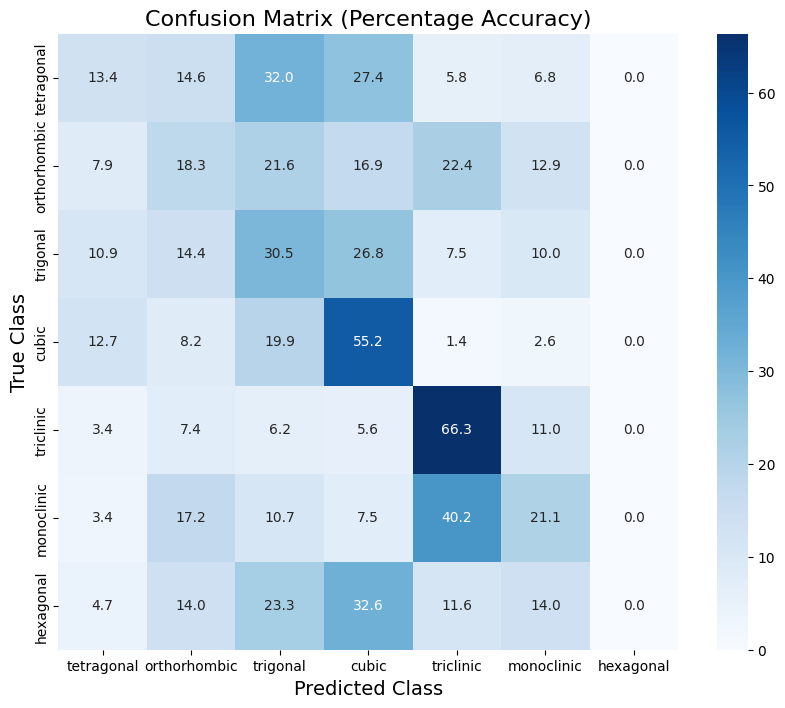

In [ ]:
model = torch.load("/content/drive/MyDrive/xrd_model_training/CNN.pt", map_location=torch.device("cpu"))
confusion_matrix_percent = evaluate_and_plot_confusion_matrix(model, test_loader, label_map)

In [ ]:
def extract_features_from_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    all_features = []
    all_labels = []

    with torch.no_grad():  # No gradient computation needed
        for inputs, labels in dataloader:
            # Transpose input to match Conv1d expected shape
            inputs = inputs.permute(0, 2, 1).to(device)  # [batch_size, channels, sequence_length]
            labels = labels.to(device)

            # Forward pass until the layer of interest
            x = torch.relu(model.conv1(inputs))
            x = model.pool(x)
            x = torch.relu(model.conv2(x))
            x = model.pool(x)
            x = model.dropout(x)
            features = model.flatten(x)  # Extract flattened features

            all_features.append(features.cpu().numpy())  # Move to CPU and convert to numpy
            all_labels.append(labels.cpu().numpy())  # Labels as numpy arrays

    # Concatenate all batches into single arrays
    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return all_features, all_labels


In [ ]:
def apply_tsne_and_visualize(features, labels):
    # Perform t-SNE dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    features_tsne = tsne.fit_transform(features)

    # Encode labels to numerical values for coloring
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)

    # Plot the t-SNE visualization
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=encoded_labels, cmap='viridis', s=10)
    plt.colorbar(scatter, label='Class Label')
    plt.title('t-SNE Visualization of XRD CNN Features')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()


<ipython-input-23-71e67e1f473e>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/content/drive/MyDrive/xrd_model_training/CNN.pt", map_location=torch.de

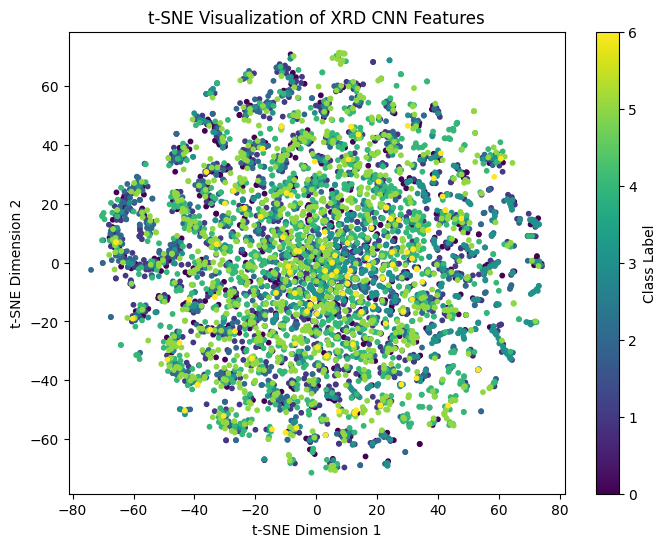

In [ ]:
model = torch.load("/content/drive/MyDrive/xrd_model_training/CNN.pt", map_location=torch.device("cpu"))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Extract features and labels
features, labels = extract_features_from_model(model, test_loader, device)

# Apply t-SNE and visualize
apply_tsne_and_visualize(features, labels)

In [ ]:
evaluate_model(model, val_loader)

In [ ]:
 torch.save(model, "/content/drive/MyDrive/xrd_model_training/CNN_2.pt")

In [ ]:
missing_files = []

for file_name, label in test_list:
    file_name = file_name.replace('.cif', '_convolved.npz')
    file_path = os.path.join(data_dir, file_name)
    if not os.path.exists(file_path):
        missing_files.append(file_path)

print(f"Missing files count: {len(missing_files)}")
print("First 10 missing files:", missing_files[:10])

Missing files count: 0
First 10 missing files: []


In [ ]:
torch.save(model, "models/CNN.pt")

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
C:\Users\USER\AppData\Local\Temp\ipykernel_31924\1578973231.py:1: SyntaxWarning: invalid escape sequence '\m'
  torch.save(model, "\models\CNN.pt")
C:\Users\USER\AppData\Local\Temp\ipykernel_31924\1578973231.py:1: SyntaxWarning: invalid escape sequence '\m'
  torch.save(model, "\models\CNN.pt")


RuntimeError: Parent directory \models does not exist.